In [1]:
import os
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix
)
from transformers import AutoTokenizer
import torch
from research.TweetDataset import TweetDataset
from research.IndoBertClassifier import IndoBertClassifier

C:\Users\dvirl\PycharmProjects\SemanticAnalysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# ==== CONFIGURATION ====
models_dir = "../../resources/best_model"  # directory containing .pt model files
test_path = "../../resources/data/all_bt_data/val.csv"  # path to your test dataset
NUM_LABELS = 5                      # adjust according to your label set
BATCH_SIZE = 16
MAX_LEN = 128

MODELS_NAME = {
    "tweet": "indolem/indobertweet-base-uncased",
    "base": "indobenchmark/indobert-base-p1"
}


In [3]:

def create_dataloader(df, tokenizer, batch_size=16):
    dataset = TweetDataset(df['tweet'].tolist(), df['label'].tolist(), tokenizer, MAX_LEN)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)


In [4]:
# ==== HELPER: DETERMINE BASE MODEL FROM FILENAME ====
def detect_base_model(filename: str) -> str:
    """Return correct model name based on file name content."""
    filename_lower = filename.lower()
    for key, model_name in MODELS_NAME.items():
        if key in filename_lower:
            return model_name
    # Default fallback
    return MODELS_NAME["base"]


In [5]:
# ==== EVALUATION FUNCTION ====
def evaluate_model(model_path):
    """Load model from path, detect base type, evaluate and plot results."""
    base_model = detect_base_model(os.path.basename(model_path))
    print(f"\n🔍 Loading model from: {model_path}")
    print(f"   → Detected base model: {base_model}")

    tokenizer = AutoTokenizer.from_pretrained(base_model)
    test_loader = create_dataloader(df_test, tokenizer, batch_size=BATCH_SIZE)
    model = IndoBertClassifier(model_name=base_model, num_labels=NUM_LABELS)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Evaluating {os.path.basename(model_path)}"):
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # ==== Compute metrics ====
    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    report = classification_report(
        all_labels, all_preds, target_names=label2id.keys(), output_dict=True
    )

    # ==== Plots ====
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    # fig.suptitle(f"{os.path.basename(model_path)} ({base_model})", fontsize=14)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, normalize='pred')
    sns.heatmap(
        cm, annot=True, fmt=".4f", cmap="Blues", ax=axes[0],
        xticklabels=id2label.values(), yticklabels=id2label.values()
    )
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    # Classification Report Heatmap
    report_df = pd.DataFrame(report).iloc[:-1, :].T
    sns.heatmap(report_df, annot=True, cmap="Blues", fmt=".4f", ax=axes[1])
    axes[1].set_title("Classification Report")

    plt.tight_layout()
    plt.show()

    return {
        'model_name': os.path.basename(model_path),
        'base_model': base_model,
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

In [6]:
# ==== LOAD TEST DATA ====
df_test = pd.read_csv(test_path)
label2id = {'love': 0, 'anger': 1, 'sadness': 2, 'happy': 3, 'fear': 4}
id2label = {v: k for k, v in label2id.items()}
df_test['label_id'] = df_test['label'].map(id2label)
df_test['labels'] = df_test['label']

df_test

,tweet,label,label_id,labels
0,Ya.....Allah..smoga 2019 tdk ada lagi 2 manusi...,4,fear,4
1,[BELAJARLAH DEMI ORANGTUAMU!!!] KALIAN TAU!! O...,1,anger,1
2,Hallo [USERNAME] Mohon dibantu ya saya sudah m...,2,sadness,2
3,Bisa gak sih situ sekali aja mikir sendiri kal...,1,anger,1
4,"Selamat pagi warga Gunungkidul, bagaimana suas...",3,happy,3
...,...,...,...,...
215,"Ada seseorang merasa pancasila, tapi anti poli...",1,anger,1
216,"Mamah adalah sumber kasih sayang, mengasuh dan...",0,love,0
217,"Dibilang baik-baik nyepelein, dimarahin malah ...",1,anger,1
218,Jalan-jalan cari suasana baru dan pengetahuan ...,3,happy,3



🔍 Loading model from: ../../resources/best_model/tweet_1pBT.pt
   → Detected base model: indolem/indobertweet-base-uncased


Evaluating tweet_1pBT.pt: 100%|██████████| 14/14 [00:29<00:00,  2.14s/it]


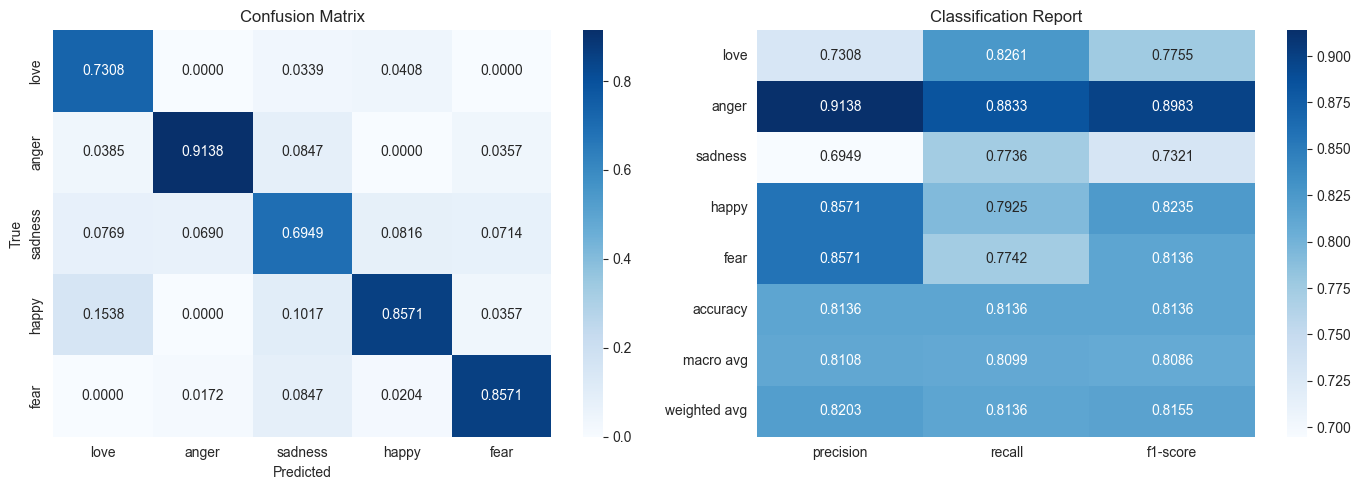

[{'model_name': 'tweet_1pBT.pt',
  'base_model': 'indolem/indobertweet-base-uncased',
  'accuracy': 0.8136363636363636,
  'f1_macro': 0.8086093759537715,
  'f1_weighted': 0.8154818591535228}]

In [7]:

# ==== RUN COMPARISON ====
results = []
for fname in os.listdir(models_dir):
    if fname.endswith(".pt"):
        model_path = f'{models_dir}/{fname}'
        res = evaluate_model(model_path)
        results.append(res)
results

In [8]:

# ==== RESULTS SUMMARY ====
results_df = pd.DataFrame(results).sort_values(by='f1_weighted', ascending=False)
display(results_df)

,model_name,base_model,accuracy,f1_macro,f1_weighted
0,tweet_1pBT.pt,indolem/indobertweet-base-uncased,0.813636,0.808609,0.815482


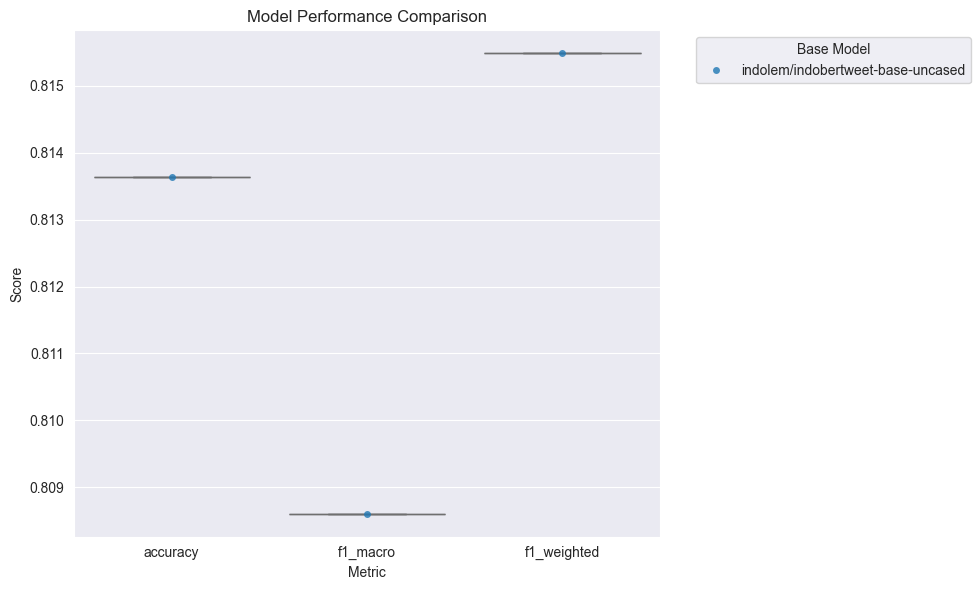

In [9]:


# ==== BOX PLOT FOR COMPARISON ====
plt.figure(figsize=(10, 6))
melted = results_df.melt(
    id_vars=['model_name', 'base_model'],
    value_vars=['accuracy', 'f1_macro', 'f1_weighted']
)
sns.boxplot(x='variable', y='value', data=melted, color='skyblue')
sns.stripplot(x='variable', y='value', data=melted, hue='base_model',
              dodge=True, marker='o', alpha=0.8)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Base Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [10]:

# ==== SAVE RESULTS ====
# results_df.to_csv("model_comparison_results.csv", index=False)
# print("✅ Results saved to model_comparison_results.csv")
